In [48]:
!pip install plyfile


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


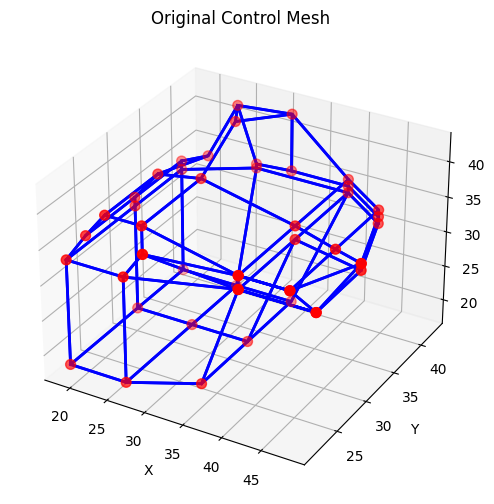

In [49]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from plyfile import PlyData

def load_control_mesh(filename):
    """
    Reads a PLY file and returns the vertex positions and face connectivity.
    
    Parameters:
        filename (str): Path to the PLY file.
        
    Returns:
        vertices (np.ndarray): (N x 3) array of vertex coordinates.
        faces (np.ndarray): Array of face definitions (each is a list of vertex indices).
    """
    plydata = PlyData.read(filename)
    vertices = np.stack(
        [plydata['vertex'].data['x'],
         plydata['vertex'].data['y'],
         plydata['vertex'].data['z']],
        axis=-1
    )
    faces = np.array(plydata['face'].data['vertex_indices'])
    return vertices, faces

def plot_mesh(vertices, faces, title="Mesh"):
    """
    Visualizes a mesh using matplotlib's 3D plotting.
    
    Parameters:
        vertices (np.ndarray): Vertex positions (N x 3).
        faces (np.ndarray): Face connectivity (list/array of lists of vertex indices).
        title (str): Plot title.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    # Plot vertices as red dots
    ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='r', s=50)
    # Draw each face’s edges in blue
    for face in faces:
        # Ensure we close the loop by appending the first index at the end
        face_indices = list(face) + [face[0]]
        pts = vertices[face_indices]
        ax.plot(pts[:,0], pts[:,1], pts[:,2], color='b', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Load one sample file (adjust the filename as needed)
filename = "sample000003.ply"
vertices, faces = load_control_mesh(filename)
plot_mesh(vertices, faces, title="Original Control Mesh")


In [50]:
# %% [code]
def create_bezier_patch_from_quad(quad):
    """
    Given a quad (4x3 array) with vertices ordered as 
    A (top-left), B (top-right), C (bottom-right), D (bottom-left),
    construct a 4x4 grid of control points representing a Bézier-like patch.
    
    Parameters:
        quad (np.ndarray): Array of shape (4,3) with the quad's vertex positions.
        
    Returns:
        grid (np.ndarray): A (4x4x3) array representing the control net.
    """
    # Unpack the corners
    A, B, C, D = quad
    # Compute the face center Q as the average of the four corners
    Q = (A + B + C + D) / 4.0

    # Initialize the 4x4 grid
    grid = np.zeros((4,4,3))
    
    # Set the corner control points
    grid[0,0] = A
    grid[0,3] = B
    grid[3,3] = C
    grid[3,0] = D

    # Define boundary control points by linear interpolation along the edges:
    # Top edge (A to B)
    grid[0,1] = A + (B - A) / 3.0
    grid[0,2] = A + 2 * (B - A) / 3.0
    # Right edge (B to C)
    grid[1,3] = B + (C - B) / 3.0
    grid[2,3] = B + 2 * (C - B) / 3.0
    # Bottom edge (D to C) — note the order from D (left) to C (right)
    grid[3,1] = D + (C - D) / 3.0
    grid[3,2] = D + 2 * (C - D) / 3.0
    # Left edge (A to D)
    grid[1,0] = A + (D - A) / 3.0
    grid[2,0] = A + 2 * (D - A) / 3.0
    
    # Define a bilinear interpolation function on the corners:
    def bilinear(s, t, A, B, C, D):
        # s, t in [0, 1]
        return (1 - t) * ((1 - s) * A + s * B) + t * ((1 - s) * D + s * C)
    
    # Compute the bilinear center at (0.5, 0.5) to find the offset
    center_bilinear = bilinear(0.5, 0.5, A, B, C, D)
    offset = Q - center_bilinear  # How much the true face center deviates from the bilinear center
    
    # Fill in the interior control points (positions [1,1], [1,2], [2,1], [2,2])
    for i in [1, 2]:
        for j in [1, 2]:
            s = i / 3.0  # i=1 -> 1/3, i=2 -> 2/3
            t = j / 3.0  # j=1 -> 1/3, j=2 -> 2/3
            grid[i, j] = bilinear(s, t, A, B, C, D) + offset

    return grid

# For demonstration, take the first face from the loaded mesh.
# Ensure that the face is a quad (i.e. has 4 vertices).
quad_indices = faces[7]  # This is an array of 4 vertex indices
quad_vertices = vertices[quad_indices]

# Here, we assume that quad_vertices are already ordered as top-left, top-right, bottom-right, bottom-left.
# In your data, you might need to reorder based on geometry.
patch_grid = create_bezier_patch_from_quad(quad_vertices)
print("4x4 control net shape:", patch_grid.shape)


4x4 control net shape: (4, 4, 3)


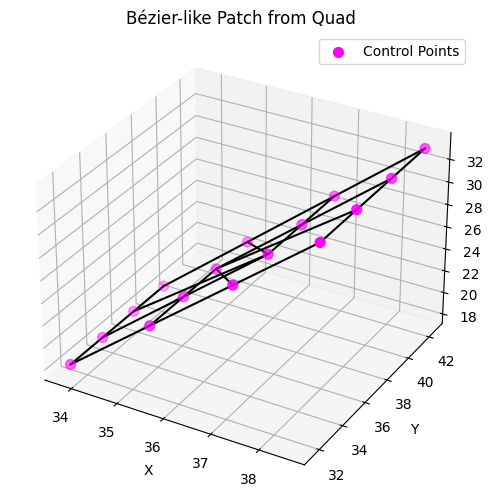

In [51]:
# %% [code]
def plot_control_net(grid, title="4x4 Control Net"):
    """
    Visualizes a 4x4 control net grid in 3D.
    
    Parameters:
        grid (np.ndarray): A (4x4x3) array of control point positions.
        title (str): Plot title.
    """
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the grid points
    pts = grid.reshape(-1, 3)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color='magenta', s=50, label='Control Points')
    
    # Draw lines for each row
    for i in range(4):
        ax.plot(grid[i,:,0], grid[i,:,1], grid[i,:,2], color='k')
    
    # Draw lines for each column
    for j in range(4):
        ax.plot(grid[:,j,0], grid[:,j,1], grid[:,j,2], color='k')
    
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()
    plt.show()

plot_control_net(patch_grid, title="Bézier-like Patch from Quad")


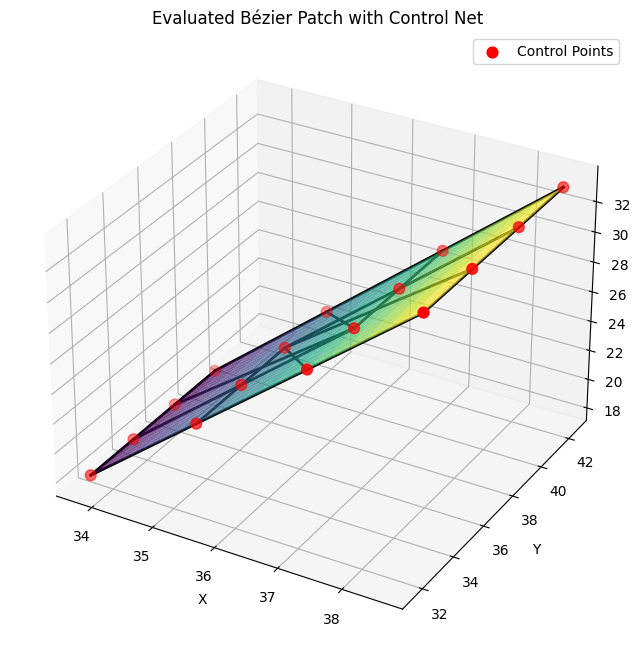

In [52]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bernstein_poly(i, n, t):
    """
    Compute the Bernstein polynomial B_{i,n}(t).
    
    For degree 3 (n=3), the coefficients are fixed: [1, 3, 3, 1].
    """
    # In our case, n is always 3.
    coeffs = [1, 3, 3, 1]
    return coeffs[i] * (t ** i) * ((1 - t) ** (n - i))

def evaluate_bezier_patch(control_grid, resolution=20):
    """
    Evaluates a bicubic Bézier patch defined by a 4x4 control grid.
    
    Parameters:
        control_grid (np.ndarray): A (4,4,3) array of control points.
        resolution (int): Number of samples along each parameter direction.
    
    Returns:
        surface_points (np.ndarray): A (resolution x resolution x 3) array of evaluated points.
    """
    # Create a grid of parameter values (u,v) in [0,1]
    u_vals = np.linspace(0, 1, resolution)
    v_vals = np.linspace(0, 1, resolution)
    surface_points = np.zeros((resolution, resolution, 3))
    
    for i, u in enumerate(u_vals):
        for j, v in enumerate(v_vals):
            point = np.zeros(3)
            # Evaluate double summation over the 4x4 control grid.
            for a in range(4):
                for b in range(4):
                    # Weight from the Bernstein polynomials in u and v.
                    weight = bernstein_poly(a, 3, u) * bernstein_poly(b, 3, v)
                    point += weight * control_grid[a, b]
            surface_points[i, j] = point
    return surface_points

# Evaluate the Bézier patch on a 20x20 grid.
patch_surface = evaluate_bezier_patch(patch_grid, resolution=20)

# %% [code]
def plot_bezier_patch(surface, control_grid, title="Evaluated Bézier Patch"):
    """
    Visualizes a Bézier patch surface along with its 4x4 control net.
    
    Parameters:
        surface (np.ndarray): (resolution x resolution x 3) evaluated patch points.
        control_grid (np.ndarray): (4x4x3) array of control points.
        title (str): Title for the plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the evaluated Bézier patch as a surface.
    # Create parameter grids for plotting.
    resolution = surface.shape[0]
    u = np.linspace(0, 1, resolution)
    v = np.linspace(0, 1, resolution)
    U, V = np.meshgrid(u, v)
    
    # Surface coordinates
    X = surface[:, :, 0]
    Y = surface[:, :, 1]
    Z = surface[:, :, 2]
    
    # Plot the surface.
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="viridis", alpha=0.7, edgecolor="none")
    
    # Overlay the control net points.
    # Plot control points as red dots.
    ctrl_pts = control_grid.reshape(-1, 3)
    ax.scatter(ctrl_pts[:, 0], ctrl_pts[:, 1], ctrl_pts[:, 2], color='red', s=60, label='Control Points')
    
    # Draw lines for the control net grid (rows and columns).
    for i in range(4):
        ax.plot(control_grid[i, :, 0], control_grid[i, :, 1], control_grid[i, :, 2],
                color='k', linewidth=2)
    for j in range(4):
        ax.plot(control_grid[:, j, 0], control_grid[:, j, 1], control_grid[:, j, 2],
                color='k', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

# Visualize the evaluated Bézier patch along with its control net.
plot_bezier_patch(patch_surface, patch_grid, title="Evaluated Bézier Patch with Control Net")


In [53]:
import numpy as np

def catmull_clark_subdivision_with_patches(vertices, faces):
    """
    Performs one iteration of Catmull-Clark subdivision and returns:
      - new_verts: The updated vertex positions.
      - new_faces: A list (array) of new faces.
      - patch_faces_map: A dictionary mapping each original face index to a list of new face indices
                         that belong to that patch.

    Assumes faces are quads.
    """
    # 1. Compute face points: average of vertices of each face.
    face_points = []
    for face in faces:
        fpt = vertices[face].mean(axis=0)
        face_points.append(fpt)
    face_points = np.array(face_points)
    
    # 2. Build an edge dictionary: keys are sorted vertex pairs, values are lists of adjacent face indices.
    edge_dict = {}
    for fi, face in enumerate(faces):
        n = len(face)
        for i in range(n):
            v1 = face[i]
            v2 = face[(i + 1) % n]
            edge = tuple(sorted((v1, v2)))
            if edge not in edge_dict:
                edge_dict[edge] = []
            edge_dict[edge].append(fi)
    
    # 3. Compute edge points.
    edge_points = {}
    for edge, face_indices in edge_dict.items():
        v1, v2 = edge
        if len(face_indices) == 2:
            f1, f2 = face_indices
            ep = (vertices[v1] + vertices[v2] + face_points[f1] + face_points[f2]) / 4.0
        else:
            # Border edge: average endpoints and the single adjacent face point.
            f1 = face_indices[0]
            ep = (vertices[v1] + vertices[v2] + face_points[f1]) / 3.0
        edge_points[edge] = ep

    # 4. Update original vertices.
    vertex_faces = {i: [] for i in range(len(vertices))}
    vertex_edges = {i: [] for i in range(len(vertices))}
    for fi, face in enumerate(faces):
        for v in face:
            vertex_faces[v].append(fi)
    for edge in edge_dict:
        v1, v2 = edge
        vertex_edges[v1].append(edge)
        vertex_edges[v2].append(edge)
    
    new_vertex_positions = []
    for i in range(len(vertices)):
        n = len(vertex_faces[i])
        if n == 0:
            new_vertex_positions.append(vertices[i])
            continue
        F = np.mean(face_points[vertex_faces[i]], axis=0)
        R = np.mean([ (vertices[edge[0]] + vertices[edge[1]]) / 2.0 for edge in vertex_edges[i] ], axis=0)
        P = vertices[i]
        new_P = (F + 2*R + (n - 3)*P) / n
        new_vertex_positions.append(new_P)
    new_vertex_positions = np.array(new_vertex_positions)
    
    # 5. Combine new vertices: start with updated original vertices,
    # then add all edge points, then face points.
    new_verts_list = new_vertex_positions.tolist()
    edge_index_mapping = {}
    for edge, ep in edge_points.items():
        edge_index_mapping[edge] = len(new_verts_list)
        new_verts_list.append(ep.tolist())
    face_index_mapping = {}
    for fi, fpt in enumerate(face_points):
        face_index_mapping[fi] = len(new_verts_list)
        new_verts_list.append(fpt.tolist())
    new_verts = np.array(new_verts_list)
    
    # 6. Construct new faces.
    new_faces = []
    patch_faces_map = {}  # mapping from original face index to list of new face indices
    for fi, face in enumerate(faces):
        n = len(face)
        f_index = face_index_mapping[fi]
        patch_faces_map[fi] = []  # initialize list for this face
        for i in range(n):
            v_current = face[i]
            v_next = face[(i+1) % n]
            # Get edge points for the edge from current to next and from previous to current.
            edge_current = edge_index_mapping[tuple(sorted((v_current, v_next)))]
            v_prev = face[i-1]
            edge_prev = edge_index_mapping[tuple(sorted((v_prev, v_current)))]
            # Create a new quad face
            new_face = [v_current, edge_current, f_index, edge_prev]
            new_face_index = len(new_faces)  # index of this newly created face
            new_faces.append(new_face)
            patch_faces_map[fi].append(new_face_index)
    
    new_faces = np.array(new_faces)
    return new_verts, new_faces, patch_faces_map

# Test the function on our control mesh.
# Assume 'vertices' and 'faces' are obtained from your PLY file (control mesh).
final_verts, final_faces, patch_map = catmull_clark_subdivision_with_patches(vertices, faces)


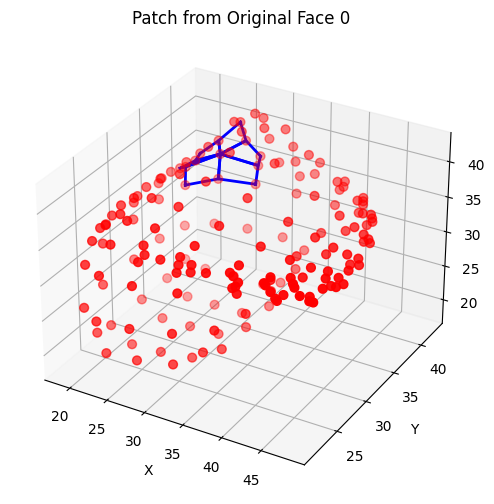

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_patch(verts, faces, patch_face_indices, title="Extracted Patch"):
    """
    Visualizes a subset of faces (patch) from the subdivided surface.
    
    Parameters:
        verts (np.ndarray): Vertex coordinates.
        faces (np.ndarray): All face definitions (list of vertex indices).
        patch_face_indices (list): Indices in 'faces' that belong to the patch.
        title (str): Plot title.
    """
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot the patch faces.
    for pfi in patch_face_indices:
        face = faces[pfi]
        # Close the face loop by appending the first vertex index.
        face_indices = list(face) + [face[0]]
        pts = verts[face_indices]
        ax.plot(pts[:,0], pts[:,1], pts[:,2], color='b', linewidth=2)
    
    # Optionally, plot the vertices.
    ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color="r", s=40)
    
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# For example, select the patch corresponding to the first original quad (face index 0).
patch_face_indices = patch_map[0]
plot_patch(final_verts, final_faces, patch_face_indices, title="Patch from Original Face 0")


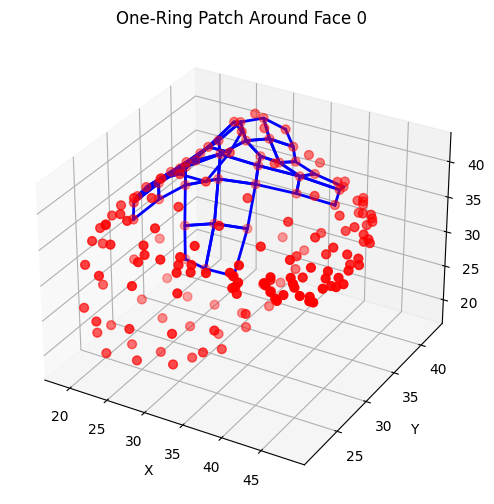

In [55]:
def get_one_ring_patch(patch_map, control_faces, face_index):
    """
    Given the mapping (patch_map) and the control faces, return the list
    of new face indices that belong to the patch and its immediate neighbors.
    
    Parameters:
        patch_map (dict): Mapping from original face index to new face indices.
        control_faces (np.ndarray): Original control mesh faces.
        face_index (int): The selected face index to extract.
    
    Returns:
        combined_patch (list): Combined list of new face indices.
    """
    # Start with the selected face's patch.
    combined_patch = set(patch_map[face_index])
    
    # Find neighbors: any control face sharing an edge with the selected face.
    selected_face = set(control_faces[face_index])
    for fi, face in enumerate(control_faces):
        if fi == face_index:
            continue
        # Check for shared vertices (this is a simple proxy for shared edge)
        if len(selected_face.intersection(face)) >= 2:
            combined_patch.update(patch_map[fi])
    return list(combined_patch)

# Get a one-ring patch around face 0.
one_ring_patch = get_one_ring_patch(patch_map, faces, 0)
plot_patch(final_verts, final_faces, one_ring_patch, title="One-Ring Patch Around Face 0")


In [56]:
def sample_quad_face(vertices, face, num_samples_u=10, num_samples_v=10):
    """
    Samples a grid of points on a quad face via bilinear interpolation.
    
    Parameters:
        vertices (np.ndarray): The array of 3D vertex positions.
        face (array-like): Four indices defining the quad (assumed in order).
        num_samples_u (int): Number of samples along the 'u' parameter.
        num_samples_v (int): Number of samples along the 'v' parameter.
    
    Returns:
        samples (np.ndarray): An array of shape (num_samples_u*num_samples_v, 3) with sampled points.
    """
    # Retrieve the four vertices (assumed order: v0, v1, v2, v3)
    v0, v1, v2, v3 = vertices[face[0]], vertices[face[1]], vertices[face[2]], vertices[face[3]]
    samples = []
    for i in range(num_samples_u):
        u = i / (num_samples_u - 1)
        for j in range(num_samples_v):
            v = j / (num_samples_v - 1)
            point = (1-u)*(1-v)*v0 + u*(1-v)*v1 + u*v*v2 + (1-u)*v*v3
            samples.append(point)
    return np.array(samples)


4x4 control net shape: (4, 4, 3)


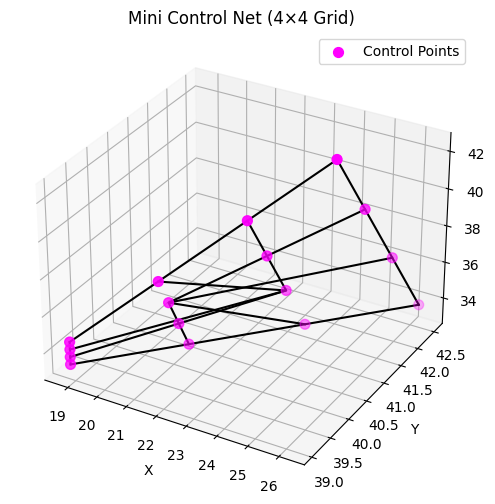

In [57]:
import numpy as np

def polygon_to_quad(poly):
    """
    Given a polygon (n x 3 array with n >= 4), project the points to a 2D plane
    using PCA and then select four vertices to approximate a quad.
    
    Strategy:
      1. Compute the centroid.
      2. Compute the 2D projection using the two principal directions.
      3. Compute angles for each vertex with respect to the centroid.
      4. Sort vertices by angle.
      5. Select four vertices at indices [0, floor(n/4), floor(n/2), floor(3n/4)].
    
    Parameters:
      poly (np.ndarray): n x 3 array of vertices.
    
    Returns:
      quad (np.ndarray): 4 x 3 array of vertices approximating the polygon as a quad.
    """
    n = poly.shape[0]
    if n < 4:
        raise ValueError("Polygon must have at least 4 vertices")
    
    # Compute centroid
    centroid = np.mean(poly, axis=0)
    pts_centered = poly - centroid
    
    # Compute PCA: we'll use SVD to get the two principal axes
    U, S, Vt = np.linalg.svd(pts_centered, full_matrices=False)
    basis = Vt[:2].T  # Use the first two principal components (3x2)
    
    # Project the points onto the 2D plane defined by the principal components.
    projected = pts_centered.dot(basis)  # n x 2
    
    # Compute polar angles of the points relative to the centroid in the 2D plane.
    angles = np.arctan2(projected[:, 1], projected[:, 0])
    
    # Sort indices by angle
    sorted_indices = np.argsort(angles)
    
    # Choose four indices, evenly spaced among the sorted order.
    idx0 = sorted_indices[0]
    idx1 = sorted_indices[int(n/4) % n]
    idx2 = sorted_indices[int(n/2) % n]
    idx3 = sorted_indices[int(3*n/4) % n]
    
    quad = np.array([poly[idx0], poly[idx1], poly[idx2], poly[idx3]])
    return quad

def create_bezier_patch_from_quad(quad):
    """
    Given a face with vertices (n x 3 array), if n != 4, approximate it as a quad.
    Then, assuming the quad's vertices are ordered as top-left, top-right, 
    bottom-right, bottom-left, construct a 4x4 grid of control points.
    
    Parameters:
      quad (np.ndarray): Array of shape (n,3); if n != 4, an approximate quad will be computed.
    
    Returns:
      grid (np.ndarray): A 4x4x3 array representing the mini control net.
    """
    # If we don't have a true quad, convert the polygon to a quad.
    if quad.shape[0] != 4:
        print(f"Warning: Face has {quad.shape[0]} vertices; approximating as a quad.")
        quad = polygon_to_quad(quad)
    
    # Unpack the corners
    A, B, C, D = quad
    # Compute the face center (Q) as the average of the four corners.
    Q = (A + B + C + D) / 4.0

    # Initialize the 4x4 grid.
    grid = np.zeros((4, 4, 3))
    
    # Set the corner control points.
    grid[0, 0] = A
    grid[0, 3] = B
    grid[3, 3] = C
    grid[3, 0] = D

    # Define boundary control points by linear interpolation along the edges.
    # Top edge (A to B)
    grid[0, 1] = A + (B - A) / 3.0
    grid[0, 2] = A + 2 * (B - A) / 3.0
    # Right edge (B to C)
    grid[1, 3] = B + (C - B) / 3.0
    grid[2, 3] = B + 2 * (C - B) / 3.0
    # Bottom edge (D to C) – note the order from D (left) to C (right)
    grid[3, 1] = D + (C - D) / 3.0
    grid[3, 2] = D + 2 * (C - D) / 3.0
    # Left edge (A to D)
    grid[1, 0] = A + (D - A) / 3.0
    grid[2, 0] = A + 2 * (D - A) / 3.0
    
    # Define bilinear interpolation function.
    def bilinear(s, t, A, B, C, D):
        return (1-t)*((1-s)*A + s*B) + t*((1-s)*D + s*C)
    
    # Compute the bilinear center and the offset from the actual face center.
    center_bilinear = bilinear(0.5, 0.5, A, B, C, D)
    offset = Q - center_bilinear
    
    # Fill in the interior control points.
    for i in [1, 2]:
        for j in [1, 2]:
            s = i / 3.0
            t = j / 3.0
            grid[i, j] = bilinear(s, t, A, B, C, D) + offset

    return grid

# Example usage with your data:
# Assume 'quad_vertices' is extracted from one face using its vertex indices.
# For example, for the first face in your data.
quad_indices = faces[0]  # This face may have more than 4 indices based on your provided file.
quad_vertices = vertices[quad_indices]
try:
    patch_control_net = create_bezier_patch_from_quad(quad_vertices)
    print("4x4 control net shape:", patch_control_net.shape)
except ValueError as e:
    print(e)



# For instance, extract the mini control net corresponding to original face 0.
quad_indices = faces[0]  # original control mesh face 0
quad_vertices = vertices[quad_indices]
patch_control_net = create_bezier_patch_from_quad(quad_vertices)

# For training, you might flatten this into a fixed‐size vector.
flattened_control_net = patch_control_net.reshape(-1)  # length 4*4*3 = 48

# Visualize the mini control net:
plot_control_net(patch_control_net, title="Mini Control Net (4×4 Grid)")


NameError: name 'sample_patch_surface' is not defined

In [61]:
def normalize_points(points):
    """
    Normalizes a set of 3D points.
    
    Parameters:
        points (np.ndarray): Array of shape (N, 3) representing N points in 3D.
    
    Returns:
        normalized_points (np.ndarray): The input points, centered (mean zero) and scaled so that the maximum norm is 1.
    """
    # Compute the centroid of the points.
    center = np.mean(points, axis=0)
    points_centered = points - center
    
    # Compute the scale: maximum distance from the origin.
    scale = np.max(np.linalg.norm(points_centered, axis=1))
    if scale == 0:
        return points_centered  # Avoid division by zero.
    
    normalized_points = points_centered / scale
    return normalized_points


# Assume you have already loaded your PLY file:
# vertices, faces = load_control_mesh("sample.ply")
# For consistency with the dataset code:
original_vertices = vertices
original_faces = faces

resolution = 20  # Resolution along u and v for surface sampling.
X_data = []      # To store the dense patch point clouds (inputs).
Y_data = []      # To store the flattened control nets (outputs).

# Loop over all faces (each face will be one training example).
for face_idx in range(len(original_faces)):
    # Extract the polygon for this face.
    poly = original_vertices[original_faces[face_idx]]  # poly is an (n x 3) array, where n may not be 4.
    
    # Create a 4x4 control net from this polygon.
    # This will "approximate" the polygon as a quad if it doesn't already have 4 vertices.
    try:
        patch_control_net = create_bezier_patch_from_quad(poly)
    except ValueError as e:
        print(f"Skipping face {face_idx} due to error: {e}")
        continue  # Skip any face that we cannot process properly.
    
    # Evaluate a smooth Bézier-like patch from the 4x4 control net.
    # This gives a dense grid of points on the surface.
    patch_surface = evaluate_bezier_patch(patch_control_net, resolution=resolution)
    
    # For consistency, reshape the surface sample from (resolution x resolution x 3)
    # to a list of points (N x 3) where N = resolution^2.
    patch_surface_points = patch_surface.reshape(-1, 3)
    
    # Optional: Normalize both the surface point cloud and the control net.
    # (Normalization is important for stable training.)
    patch_surface_norm = normalize_points(patch_surface_points)
    # For the control net, we flatten it into a fixed-length vector.
    patch_control_net_flat = patch_control_net.flatten()
    # Normalize the control net (treating it as a set of 3D points)
    cn_points = patch_control_net_flat.reshape(-1, 3)
    patch_control_net_norm = normalize_points(cn_points).flatten()
    
    # Append to our training lists.
    X_data.append(patch_surface_norm)
    Y_data.append(patch_control_net_norm)

# Convert lists to NumPy arrays.
X_data = np.array(X_data)  # Shape: (num_patches, N, 3) where N = resolution^2.
Y_data = np.array(Y_data)  # Shape: (num_patches, 48) for a 4x4 grid with 3 coordinates each.

print("X_data shape (input patches):", X_data.shape)
print("Y_data shape (control nets):", Y_data.shape)


Skipping face 38 due to error: Polygon must have at least 4 vertices
Skipping face 39 due to error: Polygon must have at least 4 vertices
Skipping face 41 due to error: Polygon must have at least 4 vertices
X_data shape (input patches): (40, 400, 3)
Y_data shape (control nets): (40, 48)


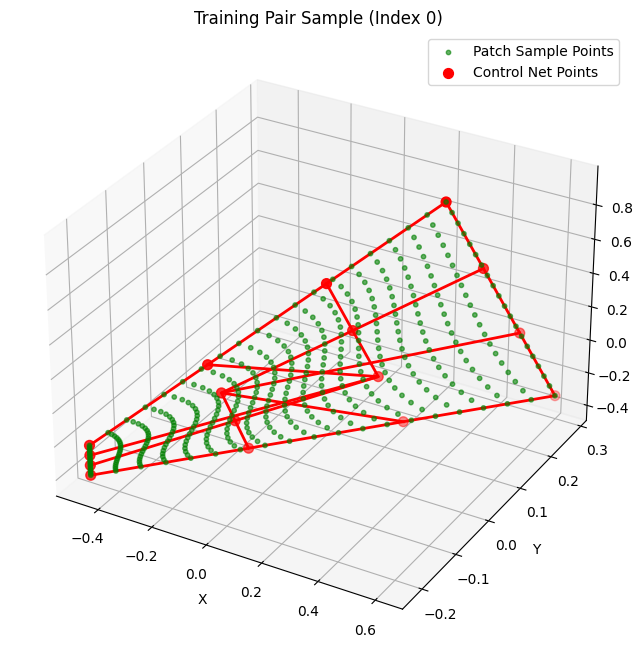

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_training_pair(X_sample, Y_sample, title="Training Pair Sample"):
    """
    Visualizes a training sample consisting of:
      - X_sample: The patch point cloud (N x 3 array)
      - Y_sample: The flattened control net (length 48, corresponding to a 4x4x3 grid)
      
    The function displays:
      - The input patch as a 3D scatter plot (green points).
      - The control net as red points arranged in a 4x4 grid with connecting lines.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot the patch point cloud (input) in green.
    ax.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2], 
               color="green", s=10, alpha=0.6, label="Patch Sample Points")
    
    # Reshape the control net into a 4x4 grid.
    if Y_sample.shape[0] == 48:
        control_net = Y_sample.reshape(4, 4, 3)
    else:
        raise ValueError("Expected flattened control net length of 48 (4x4x3)")
    
    # Plot the control net points in red.
    ax.scatter(control_net[:,:,0].flatten(), 
               control_net[:,:,1].flatten(), 
               control_net[:,:,2].flatten(),
               color="red", s=50, label="Control Net Points")
    
    # Connect the control net points along rows.
    for i in range(4):
        ax.plot(control_net[i, :, 0], control_net[i, :, 1], control_net[i, :, 2],
                color="red", linewidth=2)
    # Connect the control net points along columns.
    for j in range(4):
        ax.plot(control_net[:, j, 0], control_net[:, j, 1], control_net[:, j, 2],
                color="red", linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


# Assuming X_data and Y_data have been generated as described previously,
# visualize a sample training pair (for example, the first one).

sample_idx = 0  # Change this index to visualize different pairs.
plot_training_pair(X_data[sample_idx], Y_data[sample_idx], title="Training Pair Sample (Index 0)")
